# Import externally

In [1]:
# import sys
# import os

# # Add the parent directory to the sys.path
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# if parent_dir not in sys.path:
#     sys.path.append(parent_dir)

# Load data

In [2]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [3]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [4]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [5]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'liver_disease': 1206,
         'malignant_cancer': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'uti': 1206,
         'macroangiopathy': 1206,
         'mechanical_ventilation': 1206,
         'use_NaHCO3': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [6]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [7]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [8]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [9]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: first


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))



/media/data3/users/tubh/PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:00:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.7949187245500603
Average Accuracy: 0.7321696786804294
Average Precision: 0.6872054617791051
Average Recall: 0.5928331466965286


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))



In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.7944851803489654
Average Accuracy: 0.7288604643187819
Average Precision: 0.6761255839695848
Average Recall: 0.5971108622620381


## With validate

### Without fill missing data

/media/data3/users/tubh/PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:03:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:03:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:03:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/PredictingRiskDiabeticKetoacidosis-associatedKidn

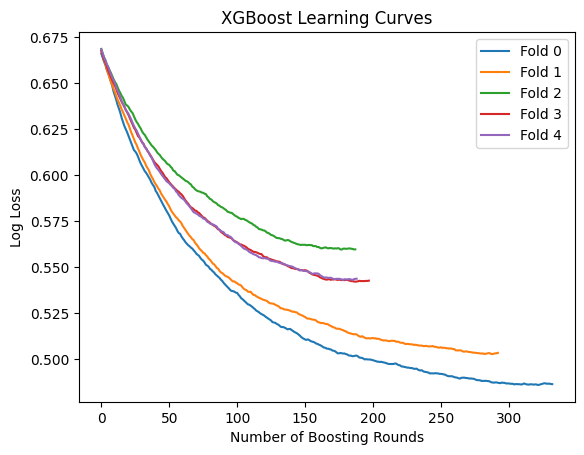

In [14]:
from utils.prepare_data import normalizeData
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from matplotlib import pyplot as plt


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
evals_result_list = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    
    evals_result = {}
    bst = xgb.train(
        params,
        xgb.DMatrix(X_train, label=y_train),
        num_boost_round=1000,
        evals=[(xgb.DMatrix(X_val, label=y_val), "validation")],
        evals_result=evals_result,
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    # model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    evals_result_list.append(evals_result)
    
    y_pred = bst.predict(xgb.DMatrix(X_test)) > 0.5
    y_pred_proba = bst.predict(xgb.DMatrix(X_test))

    # y_pred = model.predict(X_test)
    # y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))
    
    epochs = len(evals_result["validation"]["logloss"])
    x_axis = range(0, epochs)

for i, evals_result in enumerate(evals_result_list):
    epochs = len(evals_result["validation"]["logloss"])
    x_axis = range(0, epochs)

    plt.plot(x_axis, evals_result["validation"]["logloss"], label=f"Fold {i}")

plt.title("XGBoost Learning Curves")
plt.xlabel("Number of Boosting Rounds")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

<Figure size 1200x800 with 0 Axes>

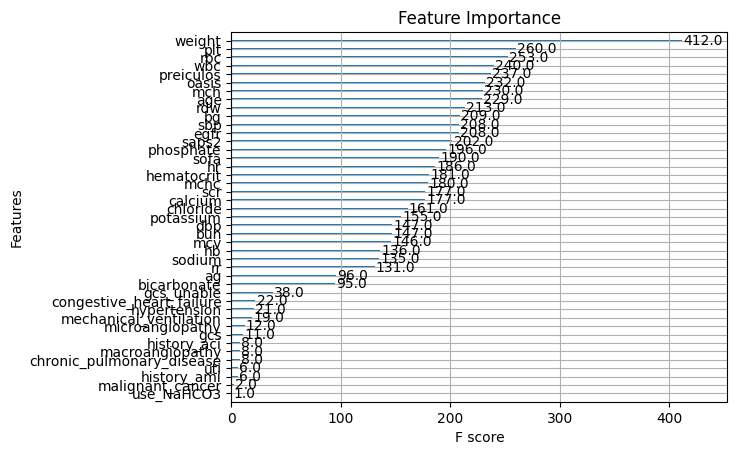

Feature importance exported successfully.


In [39]:
plt.figure(figsize=(12, 8))  # Increase figure size
xgb.plot_importance(bst)
plt.title("Feature Importance")
plt.show()

# Assuming 'model' is your trained XGBoost model
feature_importance = bst.get_score(importance_type="weight")

# Convert dictionary to DataFrame
feature_importance_df = pd.DataFrame(
    list(feature_importance.items()), columns=["Feature", "Importance"]
)

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

# Export to CSV
feature_importance_df.to_csv("feature_importance.csv", index=False)

print("Feature importance exported successfully.")

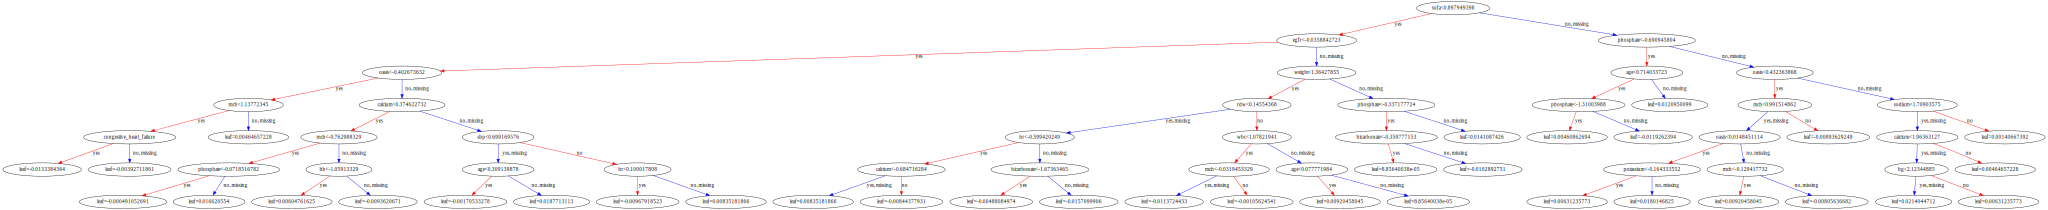

In [40]:
from xgboost import plot_tree

dot = xgb.to_graphviz(bst, num_trees=0)
dot

In [16]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.7927111508212177
Average Accuracy: 0.730509927643085
Average Precision: 0.6927591069399153
Average Recall: 0.5739081746920494


### Fill missing with knn

In [17]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))



[0]	validation_0-logloss:0.66603


[1]	validation_0-logloss:0.66293


[2]	validation_0-logloss:0.66091


[3]	validation_0-logloss:0.65864


[4]	validation_0-logloss:0.65651


[5]	validation_0-logloss:0.65405


[6]	validation_0-logloss:0.65232


[7]	validation_0-logloss:0.64977


[8]	validation_0-logloss:0.64707


[9]	validation_0-logloss:0.64540


[10]	validation_0-logloss:0.64333


[11]	validation_0-logloss:0.64130


[12]	validation_0-logloss:0.63967


[13]	validation_0-logloss:0.63790


[14]	validation_0-logloss:0.63607


[15]	validation_0-logloss:0.63381


[16]	validation_0-logloss:0.63196


[17]	validation_0-logloss:0.63034


[18]	validation_0-logloss:0.62910


[19]	validation_0-logloss:0.62757


[20]	validation_0-logloss:0.62611


[21]	validation_0-logloss:0.62440


[22]	validation_0-logloss:0.62270


[23]	validation_0-logloss:0.62096


[24]	validation_0-logloss:0.61934


[25]	validation_0-logloss:0.61726


[26]	validation_0-logloss:0.61573

[27]	validation_0-logloss:0.61431


[28]	validation_0-logloss:0.61222


[29]	validation_0-logloss:0.61028


[30]	validation_0-logloss:0.60879


[31]	validation_0-logloss:0.60744


[32]	validation_0-logloss:0.60591


[33]	validation_0-logloss:0.60524


[34]	validation_0-logloss:0.60376


[35]	validation_0-logloss:0.60225


[36]	validation_0-logloss:0.60083


[37]	validation_0-logloss:0.59961


[38]	validation_0-logloss:0.59806


[39]	validation_0-logloss:0.59688


[40]	validation_0-logloss:0.59545


[41]	validation_0-logloss:0.59398


[42]	validation_0-logloss:0.59293


[43]	validation_0-logloss:0.59182


[44]	validation_0-logloss:0.59061


[45]	validation_0-logloss:0.58940


[46]	validation_0-logloss:0.58821


[47]	validation_0-logloss:0.58693


[48]	validation_0-logloss:0.58550


[49]	validation_0-logloss:0.58442


[50]	validation_0-logloss:0.58332


[51]	validation_0-logloss:0.58220


[52]	validation_0-logloss:0.58136


[53]	validation_0-logloss:0.58000


[54]	validation_0-logloss:0.57882


[55]	validation_0-logloss:0.57767


[56]	validation_0-logloss:0.57702


[57]	validation_0-logloss:0.57567


[58]	validation_0-logloss:0.57507


[59]	validation_0-logloss:0.57416


[60]	validation_0-logloss:0.57302


[61]	validation_0-logloss:0.57206


[62]	validation_0-logloss:0.57044


[63]	validation_0-logloss:0.56916


[64]	validation_0-logloss:0.56823


[65]	validation_0-logloss:0.56714


[66]	validation_0-logloss:0.56599


[67]	validation_0-logloss:0.56534


[68]	validation_0-logloss:0.56454


[69]	validation_0-logloss:0.56413


[70]	validation_0-logloss:0.56352


[71]	validation_0-logloss:0.56269


[72]	validation_0-logloss:0.56198


[73]	validation_0-logloss:0.56073


[74]	validation_0-logloss:0.55985


[75]	validation_0-logloss:0.55938


[76]	validation_0-logloss:0.55901


[77]	validation_0-logloss:0.55807


[78]	validation_0-logloss:0.55744


[79]	validation_0-logloss:0.55683


[80]	validation_0-logloss:0.55604


[81]	validation_0-logloss:0.55512


[82]	validation_0-logloss:0.55463


[83]	validation_0-logloss:0.55396


[84]	validation_0-logloss:0.55259


[85]	validation_0-logloss:0.55223


[86]	validation_0-logloss:0.55156


[87]	validation_0-logloss:0.55097


[88]	validation_0-logloss:0.55006


[89]	validation_0-logloss:0.54965


[90]	validation_0-logloss:0.54871


[91]	validation_0-logloss:0.54863


[92]	validation_0-logloss:0.54797


[93]	validation_0-logloss:0.54724


[94]	validation_0-logloss:0.54688


[95]	validation_0-logloss:0.54620


[96]	validation_0-logloss:0.54569


[97]	validation_0-logloss:0.54507


[98]	validation_0-logloss:0.54456


[99]	validation_0-logloss:0.54399


[100]	validation_0-logloss:0.54344


[101]	validation_0-logloss:0.54280


[102]	validation_0-logloss:0.54228


[103]	validation_0-logloss:0.54165


[104]	validation_0-logloss:0.54140


[105]	validation_0-logloss:0.54045


[106]	validation_0-logloss:0.53975


[107]	validation_0-logloss:0.53915


[108]	validation_0-logloss:0.53859


[109]	validation_0-logloss:0.53782


[110]	validation_0-logloss:0.53761


[111]	validation_0-logloss:0.53746


[112]	validation_0-logloss:0.53693


[113]	validation_0-logloss:0.53670


[114]	validation_0-logloss:0.53620


[115]	validation_0-logloss:0.53581


[116]	validation_0-logloss:0.53525


[117]	validation_0-logloss:0.53477


[118]	validation_0-logloss:0.53414


[119]	validation_0-logloss:0.53368


[120]	validation_0-logloss:0.53336


[121]	validation_0-logloss:0.53294


[122]	validation_0-logloss:0.53198


[123]	validation_0-logloss:0.53147


[124]	validation_0-logloss:0.53061


[125]	validation_0-logloss:0.53003


[126]	validation_0-logloss:0.52959


[127]	validation_0-logloss:0.52922


[128]	validation_0-logloss:0.52900


[129]	validation_0-logloss:0.52839


[130]	validation_0-logloss:0.52785


[131]	validation_0-logloss:0.52750


[132]	validation_0-logloss:0.52700


[133]	validation_0-logloss:0.52643


[134]	validation_0-logloss:0.52659


[135]	validation_0-logloss:0.52637


[136]	validation_0-logloss:0.52598


[137]	validation_0-logloss:0.52555


[138]	validation_0-logloss:0.52538


[139]	validation_0-logloss:0.52511


[140]	validation_0-logloss:0.52488


[141]	validation_0-logloss:0.52480


[142]	validation_0-logloss:0.52474


[143]	validation_0-logloss:0.52437


[144]	validation_0-logloss:0.52423


[145]	validation_0-logloss:0.52428


[146]	validation_0-logloss:0.52346


[147]	validation_0-logloss:0.52294


[148]	validation_0-logloss:0.52267


[149]	validation_0-logloss:0.52261


[150]	validation_0-logloss:0.52242


[151]	validation_0-logloss:0.52194


[152]	validation_0-logloss:0.52161


[153]	validation_0-logloss:0.52130


[154]	validation_0-logloss:0.52111


[155]	validation_0-logloss:0.52093


[156]	validation_0-logloss:0.52056


[157]	validation_0-logloss:0.52032


[158]	validation_0-logloss:0.51992


[159]	validation_0-logloss:0.51963


[160]	validation_0-logloss:0.51956


[161]	validation_0-logloss:0.51910


[162]	validation_0-logloss:0.51904


[163]	validation_0-logloss:0.51857


[164]	validation_0-logloss:0.51814


[165]	validation_0-logloss:0.51778


[166]	validation_0-logloss:0.51758


[167]	validation_0-logloss:0.51759


[168]	validation_0-logloss:0.51738


[169]	validation_0-logloss:0.51758


[170]	validation_0-logloss:0.51700


[171]	validation_0-logloss:0.51670


[172]	validation_0-logloss:0.51651


[173]	validation_0-logloss:0.51636


[174]	validation_0-logloss:0.51596


[175]	validation_0-logloss:0.51552


[176]	validation_0-logloss:0.51549


[177]	validation_0-logloss:0.51530


[178]	validation_0-logloss:0.51503


[179]	validation_0-logloss:0.51497


[180]	validation_0-logloss:0.51464


[181]	validation_0-logloss:0.51441


[182]	validation_0-logloss:0.51387


[183]	validation_0-logloss:0.51371


[184]	validation_0-logloss:0.51324


[185]	validation_0-logloss:0.51327


[186]	validation_0-logloss:0.51296


[187]	validation_0-logloss:0.51285


[188]	validation_0-logloss:0.51237


[189]	validation_0-logloss:0.51213


[190]	validation_0-logloss:0.51169


[191]	validation_0-logloss:0.51163


[192]	validation_0-logloss:0.51173


[193]	validation_0-logloss:0.51143


[194]	validation_0-logloss:0.51150


[195]	validation_0-logloss:0.51115


[196]	validation_0-logloss:0.51100


[197]	validation_0-logloss:0.51061


[198]	validation_0-logloss:0.51051


[199]	validation_0-logloss:0.51022


[200]	validation_0-logloss:0.51028


[201]	validation_0-logloss:0.51024


[202]	validation_0-logloss:0.50994


[203]	validation_0-logloss:0.50993


[204]	validation_0-logloss:0.50960


[205]	validation_0-logloss:0.50969


[206]	validation_0-logloss:0.50961


[207]	validation_0-logloss:0.50953


[208]	validation_0-logloss:0.50934


[209]	validation_0-logloss:0.50944


[210]	validation_0-logloss:0.50952


[211]	validation_0-logloss:0.50937


[212]	validation_0-logloss:0.50948


[213]	validation_0-logloss:0.50894


[214]	validation_0-logloss:0.50890


[215]	validation_0-logloss:0.50870


[216]	validation_0-logloss:0.50855


[217]	validation_0-logloss:0.50837


[218]	validation_0-logloss:0.50837


[219]	validation_0-logloss:0.50835


[220]	validation_0-logloss:0.50809


[221]	validation_0-logloss:0.50798


[222]	validation_0-logloss:0.50782


[223]	validation_0-logloss:0.50753


[224]	validation_0-logloss:0.50732


[225]	validation_0-logloss:0.50704


[226]	validation_0-logloss:0.50675


[227]	validation_0-logloss:0.50677


[228]	validation_0-logloss:0.50643


[229]	validation_0-logloss:0.50637


[230]	validation_0-logloss:0.50624


[231]	validation_0-logloss:0.50618


[232]	validation_0-logloss:0.50615


[233]	validation_0-logloss:0.50614


[234]	validation_0-logloss:0.50649


[235]	validation_0-logloss:0.50630


[236]	validation_0-logloss:0.50632


[237]	validation_0-logloss:0.50604


[238]	validation_0-logloss:0.50567


[239]	validation_0-logloss:0.50567


[240]	validation_0-logloss:0.50554


[241]	validation_0-logloss:0.50538


[242]	validation_0-logloss:0.50497


[243]	validation_0-logloss:0.50491


[244]	validation_0-logloss:0.50485


[245]	validation_0-logloss:0.50496


[246]	validation_0-logloss:0.50488


[247]	validation_0-logloss:0.50486


[248]	validation_0-logloss:0.50464


[249]	validation_0-logloss:0.50431


[250]	validation_0-logloss:0.50418


[251]	validation_0-logloss:0.50395


[252]	validation_0-logloss:0.50436


[253]	validation_0-logloss:0.50450


[254]	validation_0-logloss:0.50430


[255]	validation_0-logloss:0.50435


[256]	validation_0-logloss:0.50401


[257]	validation_0-logloss:0.50393


[258]	validation_0-logloss:0.50358


[259]	validation_0-logloss:0.50322


[260]	validation_0-logloss:0.50327


[261]	validation_0-logloss:0.50355


[262]	validation_0-logloss:0.50338


[263]	validation_0-logloss:0.50325


[264]	validation_0-logloss:0.50328


[265]	validation_0-logloss:0.50315


[266]	validation_0-logloss:0.50306


[267]	validation_0-logloss:0.50311


[268]	validation_0-logloss:0.50299


[269]	validation_0-logloss:0.50289


[270]	validation_0-logloss:0.50287


[271]	validation_0-logloss:0.50291


[272]	validation_0-logloss:0.50258


[273]	validation_0-logloss:0.50264


[274]	validation_0-logloss:0.50257


[275]	validation_0-logloss:0.50264


[276]	validation_0-logloss:0.50251


[277]	validation_0-logloss:0.50227


[278]	validation_0-logloss:0.50259


[279]	validation_0-logloss:0.50218


[280]	validation_0-logloss:0.50214


[281]	validation_0-logloss:0.50203


[282]	validation_0-logloss:0.50218


[283]	validation_0-logloss:0.50211


[284]	validation_0-logloss:0.50219


[285]	validation_0-logloss:0.50233


[286]	validation_0-logloss:0.50234


[287]	validation_0-logloss:0.50213


[288]	validation_0-logloss:0.50229


[289]	validation_0-logloss:0.50229


[290]	validation_0-logloss:0.50244


[0]	validation_0-logloss:0.66755


[1]	validation_0-logloss:0.66526


[2]	validation_0-logloss:0.66245


[3]	validation_0-logloss:0.66038


[4]	validation_0-logloss:0.65820


[5]	validation_0-logloss:0.65591


[6]	validation_0-logloss:0.65479


[7]	validation_0-logloss:0.65293


[8]	validation_0-logloss:0.65090


[9]	validation_0-logloss:0.64925


[10]	validation_0-logloss:0.64781


[11]	validation_0-logloss:0.64544


[12]	validation_0-logloss:0.64423


[13]	validation_0-logloss:0.64188


[14]	validation_0-logloss:0.64033


[15]	validation_0-logloss:0.63871


[16]	validation_0-logloss:0.63702


[17]	validation_0-logloss:0.63520


[18]	validation_0-logloss:0.63362


[19]	validation_0-logloss:0.63179


[20]	validation_0-logloss:0.63009


[21]	validation_0-logloss:0.62817


[22]	validation_0-logloss:0.62645


[23]	validation_0-logloss:0.62521


[24]	validation_0-logloss:0.62327


[25]	validation_0-logloss:0.62164


[26]	validation_0-logloss:0.62005


[27]	validation_0-logloss:0.61901


[28]	validation_0-logloss:0.61796


[29]	validation_0-logloss:0.61661


[30]	validation_0-logloss:0.61537


[31]	validation_0-logloss:0.61410


[32]	validation_0-logloss:0.61336


[33]	validation_0-logloss:0.61183


[34]	validation_0-logloss:0.61031


[35]	validation_0-logloss:0.60860


[36]	validation_0-logloss:0.60676


[37]	validation_0-logloss:0.60539


[38]	validation_0-logloss:0.60356


[39]	validation_0-logloss:0.60162


[40]	validation_0-logloss:0.60044


[41]	validation_0-logloss:0.59922


[42]	validation_0-logloss:0.59793


[43]	validation_0-logloss:0.59732


[44]	validation_0-logloss:0.59611


[45]	validation_0-logloss:0.59506


[46]	validation_0-logloss:0.59395


[47]	validation_0-logloss:0.59317


[48]	validation_0-logloss:0.59213


[49]	validation_0-logloss:0.59141


[50]	validation_0-logloss:0.59049


[51]	validation_0-logloss:0.58919


[52]	validation_0-logloss:0.58829


[53]	validation_0-logloss:0.58772


[54]	validation_0-logloss:0.58675


[55]	validation_0-logloss:0.58579


[56]	validation_0-logloss:0.58469


[57]	validation_0-logloss:0.58325


[58]	validation_0-logloss:0.58250


[59]	validation_0-logloss:0.58216


[60]	validation_0-logloss:0.58142


[61]	validation_0-logloss:0.58058


[62]	validation_0-logloss:0.57953


[63]	validation_0-logloss:0.57852


[64]	validation_0-logloss:0.57738


[65]	validation_0-logloss:0.57646


[66]	validation_0-logloss:0.57546


[67]	validation_0-logloss:0.57465


[68]	validation_0-logloss:0.57342


[69]	validation_0-logloss:0.57276


[70]	validation_0-logloss:0.57190


[71]	validation_0-logloss:0.57125


[72]	validation_0-logloss:0.57063


[73]	validation_0-logloss:0.56972


[74]	validation_0-logloss:0.56903


[75]	validation_0-logloss:0.56836


[76]	validation_0-logloss:0.56744


[77]	validation_0-logloss:0.56712


[78]	validation_0-logloss:0.56600


[79]	validation_0-logloss:0.56480


[80]	validation_0-logloss:0.56398


[81]	validation_0-logloss:0.56286


[82]	validation_0-logloss:0.56212


[83]	validation_0-logloss:0.56153


[84]	validation_0-logloss:0.56029


[85]	validation_0-logloss:0.55977


[86]	validation_0-logloss:0.55885


[87]	validation_0-logloss:0.55818


[88]	validation_0-logloss:0.55727


[89]	validation_0-logloss:0.55643


[90]	validation_0-logloss:0.55576


[91]	validation_0-logloss:0.55512


[92]	validation_0-logloss:0.55453


[93]	validation_0-logloss:0.55351


[94]	validation_0-logloss:0.55269


[95]	validation_0-logloss:0.55194


[96]	validation_0-logloss:0.55153


[97]	validation_0-logloss:0.55053


[98]	validation_0-logloss:0.55009


[99]	validation_0-logloss:0.54955


[100]	validation_0-logloss:0.54889


[101]	validation_0-logloss:0.54776


[102]	validation_0-logloss:0.54719


[103]	validation_0-logloss:0.54644


[104]	validation_0-logloss:0.54597


[105]	validation_0-logloss:0.54535


[106]	validation_0-logloss:0.54507


[107]	validation_0-logloss:0.54456


[108]	validation_0-logloss:0.54416


[109]	validation_0-logloss:0.54338


[110]	validation_0-logloss:0.54313


[111]	validation_0-logloss:0.54236


[112]	validation_0-logloss:0.54178


[113]	validation_0-logloss:0.54185


[114]	validation_0-logloss:0.54117


[115]	validation_0-logloss:0.54095


[116]	validation_0-logloss:0.54099


[117]	validation_0-logloss:0.54029


[118]	validation_0-logloss:0.53969


[119]	validation_0-logloss:0.53911


[120]	validation_0-logloss:0.53850


[121]	validation_0-logloss:0.53805


[122]	validation_0-logloss:0.53779


[123]	validation_0-logloss:0.53743


[124]	validation_0-logloss:0.53691


[125]	validation_0-logloss:0.53634


[126]	validation_0-logloss:0.53584


[127]	validation_0-logloss:0.53527


[128]	validation_0-logloss:0.53486


[129]	validation_0-logloss:0.53433


[130]	validation_0-logloss:0.53395


[131]	validation_0-logloss:0.53364


[132]	validation_0-logloss:0.53351


[133]	validation_0-logloss:0.53341


[134]	validation_0-logloss:0.53292


[135]	validation_0-logloss:0.53265


[136]	validation_0-logloss:0.53221


[137]	validation_0-logloss:0.53215


[138]	validation_0-logloss:0.53237


[139]	validation_0-logloss:0.53154


[140]	validation_0-logloss:0.53149


[141]	validation_0-logloss:0.53115


[142]	validation_0-logloss:0.53097


[143]	validation_0-logloss:0.53063


[144]	validation_0-logloss:0.53032


[145]	validation_0-logloss:0.53001


[146]	validation_0-logloss:0.52999


[147]	validation_0-logloss:0.52968


[148]	validation_0-logloss:0.52927


[149]	validation_0-logloss:0.52933


[150]	validation_0-logloss:0.52911


[151]	validation_0-logloss:0.52885


[152]	validation_0-logloss:0.52860


[153]	validation_0-logloss:0.52861


[154]	validation_0-logloss:0.52832


[155]	validation_0-logloss:0.52820


[156]	validation_0-logloss:0.52798


[157]	validation_0-logloss:0.52798


[158]	validation_0-logloss:0.52749


[159]	validation_0-logloss:0.52725


[160]	validation_0-logloss:0.52723


[161]	validation_0-logloss:0.52710


[162]	validation_0-logloss:0.52684


[163]	validation_0-logloss:0.52698


[164]	validation_0-logloss:0.52683


[165]	validation_0-logloss:0.52654


[166]	validation_0-logloss:0.52613


[167]	validation_0-logloss:0.52585


[168]	validation_0-logloss:0.52595


[169]	validation_0-logloss:0.52568


[170]	validation_0-logloss:0.52573


[171]	validation_0-logloss:0.52553


[172]	validation_0-logloss:0.52516


[173]	validation_0-logloss:0.52427


[174]	validation_0-logloss:0.52418


[175]	validation_0-logloss:0.52403


[176]	validation_0-logloss:0.52408


[177]	validation_0-logloss:0.52393


[178]	validation_0-logloss:0.52358


[179]	validation_0-logloss:0.52325


[180]	validation_0-logloss:0.52331


[181]	validation_0-logloss:0.52303


[182]	validation_0-logloss:0.52244


[183]	validation_0-logloss:0.52206


[184]	validation_0-logloss:0.52193


[185]	validation_0-logloss:0.52194


[186]	validation_0-logloss:0.52150


[187]	validation_0-logloss:0.52122


[188]	validation_0-logloss:0.52125


[189]	validation_0-logloss:0.52118


[190]	validation_0-logloss:0.52077


[191]	validation_0-logloss:0.52052


[192]	validation_0-logloss:0.51997


[193]	validation_0-logloss:0.51978


[194]	validation_0-logloss:0.51940


[195]	validation_0-logloss:0.51929


[196]	validation_0-logloss:0.51933


[197]	validation_0-logloss:0.51916


[198]	validation_0-logloss:0.51892


[199]	validation_0-logloss:0.51872


[200]	validation_0-logloss:0.51887


[201]	validation_0-logloss:0.51873


[202]	validation_0-logloss:0.51877


[203]	validation_0-logloss:0.51905


[204]	validation_0-logloss:0.51885


[205]	validation_0-logloss:0.51864


[206]	validation_0-logloss:0.51857


[207]	validation_0-logloss:0.51831


[208]	validation_0-logloss:0.51813


[209]	validation_0-logloss:0.51764


[210]	validation_0-logloss:0.51784


[211]	validation_0-logloss:0.51766


[212]	validation_0-logloss:0.51767


[213]	validation_0-logloss:0.51744


[214]	validation_0-logloss:0.51728


[215]	validation_0-logloss:0.51722


[216]	validation_0-logloss:0.51685


[217]	validation_0-logloss:0.51668


[218]	validation_0-logloss:0.51668


[219]	validation_0-logloss:0.51659


[220]	validation_0-logloss:0.51641


[221]	validation_0-logloss:0.51640


[222]	validation_0-logloss:0.51651


[223]	validation_0-logloss:0.51609


[224]	validation_0-logloss:0.51597


[225]	validation_0-logloss:0.51588


[226]	validation_0-logloss:0.51563


[227]	validation_0-logloss:0.51568


[228]	validation_0-logloss:0.51559


[229]	validation_0-logloss:0.51517


[230]	validation_0-logloss:0.51489


[231]	validation_0-logloss:0.51465


[232]	validation_0-logloss:0.51469


[233]	validation_0-logloss:0.51447


[234]	validation_0-logloss:0.51442


[235]	validation_0-logloss:0.51443


[236]	validation_0-logloss:0.51423


[237]	validation_0-logloss:0.51407


[238]	validation_0-logloss:0.51436


[239]	validation_0-logloss:0.51396


[240]	validation_0-logloss:0.51390


[241]	validation_0-logloss:0.51377


[242]	validation_0-logloss:0.51383


[243]	validation_0-logloss:0.51359


[244]	validation_0-logloss:0.51319


[245]	validation_0-logloss:0.51323


[246]	validation_0-logloss:0.51314


[247]	validation_0-logloss:0.51287


[248]	validation_0-logloss:0.51279


[249]	validation_0-logloss:0.51281


[250]	validation_0-logloss:0.51279


[251]	validation_0-logloss:0.51265


[252]	validation_0-logloss:0.51268


[253]	validation_0-logloss:0.51276


[254]	validation_0-logloss:0.51269


[255]	validation_0-logloss:0.51259


[256]	validation_0-logloss:0.51242


[257]	validation_0-logloss:0.51241


[258]	validation_0-logloss:0.51244


[259]	validation_0-logloss:0.51234


[260]	validation_0-logloss:0.51236


[261]	validation_0-logloss:0.51236


[262]	validation_0-logloss:0.51240


[263]	validation_0-logloss:0.51242


[264]	validation_0-logloss:0.51245


[265]	validation_0-logloss:0.51256


[266]	validation_0-logloss:0.51272


[267]	validation_0-logloss:0.51237


[268]	validation_0-logloss:0.51277


[0]	validation_0-logloss:0.66810


[1]	validation_0-logloss:0.66593


[2]	validation_0-logloss:0.66399


[3]	validation_0-logloss:0.66237


[4]	validation_0-logloss:0.66007


[5]	validation_0-logloss:0.65908


[6]	validation_0-logloss:0.65799


[7]	validation_0-logloss:0.65629


[8]	validation_0-logloss:0.65476


[9]	validation_0-logloss:0.65269


[10]	validation_0-logloss:0.65165


[11]	validation_0-logloss:0.64989


[12]	validation_0-logloss:0.64833


[13]	validation_0-logloss:0.64685


[14]	validation_0-logloss:0.64495


[15]	validation_0-logloss:0.64321


[16]	validation_0-logloss:0.64241


[17]	validation_0-logloss:0.64071


[18]	validation_0-logloss:0.63942


[19]	validation_0-logloss:0.63822


[20]	validation_0-logloss:0.63656


[21]	validation_0-logloss:0.63514


[22]	validation_0-logloss:0.63383


[23]	validation_0-logloss:0.63246


[24]	validation_0-logloss:0.63092


[25]	validation_0-logloss:0.62953


[26]	validation_0-logloss:0.62814


[27]	validation_0-logloss:0.62708


[28]	validation_0-logloss:0.62599


[29]	validation_0-logloss:0.62523


[30]	validation_0-logloss:0.62422


[31]	validation_0-logloss:0.62337


[32]	validation_0-logloss:0.62237


[33]	validation_0-logloss:0.62148


[34]	validation_0-logloss:0.62104


[35]	validation_0-logloss:0.61964


[36]	validation_0-logloss:0.61804


[37]	validation_0-logloss:0.61739


[38]	validation_0-logloss:0.61668


[39]	validation_0-logloss:0.61511


[40]	validation_0-logloss:0.61422


[41]	validation_0-logloss:0.61371


[42]	validation_0-logloss:0.61336


[43]	validation_0-logloss:0.61219


[44]	validation_0-logloss:0.61122


[45]	validation_0-logloss:0.61043


[46]	validation_0-logloss:0.60930


[47]	validation_0-logloss:0.60765


[48]	validation_0-logloss:0.60672


[49]	validation_0-logloss:0.60564


[50]	validation_0-logloss:0.60492


[51]	validation_0-logloss:0.60397


[52]	validation_0-logloss:0.60345


[53]	validation_0-logloss:0.60233


[54]	validation_0-logloss:0.60149


[55]	validation_0-logloss:0.60074


[56]	validation_0-logloss:0.59993


[57]	validation_0-logloss:0.59942


[58]	validation_0-logloss:0.59911


[59]	validation_0-logloss:0.59811


[60]	validation_0-logloss:0.59768


[61]	validation_0-logloss:0.59655


[62]	validation_0-logloss:0.59587


[63]	validation_0-logloss:0.59466


[64]	validation_0-logloss:0.59409


[65]	validation_0-logloss:0.59387


[66]	validation_0-logloss:0.59325


[67]	validation_0-logloss:0.59283


[68]	validation_0-logloss:0.59265


[69]	validation_0-logloss:0.59233


[70]	validation_0-logloss:0.59195


[71]	validation_0-logloss:0.59157


[72]	validation_0-logloss:0.59100


[73]	validation_0-logloss:0.58999


[74]	validation_0-logloss:0.58918


[75]	validation_0-logloss:0.58847


[76]	validation_0-logloss:0.58793


[77]	validation_0-logloss:0.58751


[78]	validation_0-logloss:0.58681


[79]	validation_0-logloss:0.58610


[80]	validation_0-logloss:0.58571


[81]	validation_0-logloss:0.58533


[82]	validation_0-logloss:0.58461


[83]	validation_0-logloss:0.58384


[84]	validation_0-logloss:0.58318


[85]	validation_0-logloss:0.58258


[86]	validation_0-logloss:0.58177


[87]	validation_0-logloss:0.58117


[88]	validation_0-logloss:0.58044


[89]	validation_0-logloss:0.58035


[90]	validation_0-logloss:0.57994


[91]	validation_0-logloss:0.57976


[92]	validation_0-logloss:0.57943


[93]	validation_0-logloss:0.57905


[94]	validation_0-logloss:0.57854


[95]	validation_0-logloss:0.57808


[96]	validation_0-logloss:0.57795


[97]	validation_0-logloss:0.57786


[98]	validation_0-logloss:0.57710


[99]	validation_0-logloss:0.57670


[100]	validation_0-logloss:0.57680


[101]	validation_0-logloss:0.57638


[102]	validation_0-logloss:0.57641


[103]	validation_0-logloss:0.57614


[104]	validation_0-logloss:0.57548


[105]	validation_0-logloss:0.57522


[106]	validation_0-logloss:0.57494


[107]	validation_0-logloss:0.57481


[108]	validation_0-logloss:0.57444


[109]	validation_0-logloss:0.57434


[110]	validation_0-logloss:0.57400


[111]	validation_0-logloss:0.57377


[112]	validation_0-logloss:0.57340


[113]	validation_0-logloss:0.57278


[114]	validation_0-logloss:0.57273


[115]	validation_0-logloss:0.57211


[116]	validation_0-logloss:0.57183


[117]	validation_0-logloss:0.57185


[118]	validation_0-logloss:0.57151


[119]	validation_0-logloss:0.57116


[120]	validation_0-logloss:0.57118


[121]	validation_0-logloss:0.57112


[122]	validation_0-logloss:0.57091


[123]	validation_0-logloss:0.57037


[124]	validation_0-logloss:0.57054


[125]	validation_0-logloss:0.57053


[126]	validation_0-logloss:0.57062


[127]	validation_0-logloss:0.57041


[128]	validation_0-logloss:0.57010


[129]	validation_0-logloss:0.57005


[130]	validation_0-logloss:0.56996


[131]	validation_0-logloss:0.57001


[132]	validation_0-logloss:0.56978


[133]	validation_0-logloss:0.56952


[134]	validation_0-logloss:0.56931


[135]	validation_0-logloss:0.56929


[136]	validation_0-logloss:0.56892


[137]	validation_0-logloss:0.56863


[138]	validation_0-logloss:0.56826


[139]	validation_0-logloss:0.56801


[140]	validation_0-logloss:0.56769


[141]	validation_0-logloss:0.56743


[142]	validation_0-logloss:0.56725


[143]	validation_0-logloss:0.56716


[144]	validation_0-logloss:0.56708


[145]	validation_0-logloss:0.56677


[146]	validation_0-logloss:0.56621


[147]	validation_0-logloss:0.56627


[148]	validation_0-logloss:0.56604


[149]	validation_0-logloss:0.56559


[150]	validation_0-logloss:0.56536


[151]	validation_0-logloss:0.56529


[152]	validation_0-logloss:0.56480


[153]	validation_0-logloss:0.56485


[154]	validation_0-logloss:0.56451


[155]	validation_0-logloss:0.56396


[156]	validation_0-logloss:0.56368


[157]	validation_0-logloss:0.56333


[158]	validation_0-logloss:0.56304


[159]	validation_0-logloss:0.56300


[160]	validation_0-logloss:0.56290


[161]	validation_0-logloss:0.56332


[162]	validation_0-logloss:0.56319


[163]	validation_0-logloss:0.56330


[164]	validation_0-logloss:0.56333


[165]	validation_0-logloss:0.56313


[166]	validation_0-logloss:0.56302


[167]	validation_0-logloss:0.56265


[168]	validation_0-logloss:0.56277


[169]	validation_0-logloss:0.56270


[170]	validation_0-logloss:0.56284


[171]	validation_0-logloss:0.56290


[172]	validation_0-logloss:0.56271


[173]	validation_0-logloss:0.56257


[174]	validation_0-logloss:0.56240


[175]	validation_0-logloss:0.56204


[176]	validation_0-logloss:0.56224


[177]	validation_0-logloss:0.56209


[178]	validation_0-logloss:0.56214


[179]	validation_0-logloss:0.56197


[180]	validation_0-logloss:0.56172


[181]	validation_0-logloss:0.56121


[182]	validation_0-logloss:0.56085


[183]	validation_0-logloss:0.56080


[184]	validation_0-logloss:0.56060


[185]	validation_0-logloss:0.56035


[186]	validation_0-logloss:0.56024


[187]	validation_0-logloss:0.56015


[188]	validation_0-logloss:0.56000


[189]	validation_0-logloss:0.56004


[190]	validation_0-logloss:0.55975


[191]	validation_0-logloss:0.55995


[192]	validation_0-logloss:0.55941


[193]	validation_0-logloss:0.55948


[194]	validation_0-logloss:0.55906


[195]	validation_0-logloss:0.55904


[196]	validation_0-logloss:0.55894


[197]	validation_0-logloss:0.55902


[198]	validation_0-logloss:0.55891


[199]	validation_0-logloss:0.55917


[200]	validation_0-logloss:0.55907


[201]	validation_0-logloss:0.55921


[202]	validation_0-logloss:0.55926


[203]	validation_0-logloss:0.55956


[204]	validation_0-logloss:0.55970


[205]	validation_0-logloss:0.56018


[206]	validation_0-logloss:0.56007


[207]	validation_0-logloss:0.55981


[208]	validation_0-logloss:0.55994


[0]	validation_0-logloss:0.66761


[1]	validation_0-logloss:0.66610


[2]	validation_0-logloss:0.66348


[3]	validation_0-logloss:0.66158


[4]	validation_0-logloss:0.65912


[5]	validation_0-logloss:0.65667


[6]	validation_0-logloss:0.65480


[7]	validation_0-logloss:0.65301


[8]	validation_0-logloss:0.65112


[9]	validation_0-logloss:0.64936


[10]	validation_0-logloss:0.64706


[11]	validation_0-logloss:0.64549


[12]	validation_0-logloss:0.64422


[13]	validation_0-logloss:0.64277


[14]	validation_0-logloss:0.64134


[15]	validation_0-logloss:0.64004


[16]	validation_0-logloss:0.63801


[17]	validation_0-logloss:0.63611


[18]	validation_0-logloss:0.63518


[19]	validation_0-logloss:0.63406


[20]	validation_0-logloss:0.63282


[21]	validation_0-logloss:0.63166


[22]	validation_0-logloss:0.62991


[23]	validation_0-logloss:0.62868


[24]	validation_0-logloss:0.62688


[25]	validation_0-logloss:0.62501


[26]	validation_0-logloss:0.62350


[27]	validation_0-logloss:0.62207


[28]	validation_0-logloss:0.62038


[29]	validation_0-logloss:0.61874


[30]	validation_0-logloss:0.61741


[31]	validation_0-logloss:0.61614


[32]	validation_0-logloss:0.61483


[33]	validation_0-logloss:0.61355


[34]	validation_0-logloss:0.61220


[35]	validation_0-logloss:0.61040


[36]	validation_0-logloss:0.60918


[37]	validation_0-logloss:0.60857


[38]	validation_0-logloss:0.60764


[39]	validation_0-logloss:0.60635


[40]	validation_0-logloss:0.60550


[41]	validation_0-logloss:0.60492


[42]	validation_0-logloss:0.60357


[43]	validation_0-logloss:0.60246


[44]	validation_0-logloss:0.60207


[45]	validation_0-logloss:0.60146


[46]	validation_0-logloss:0.60014


[47]	validation_0-logloss:0.59886


[48]	validation_0-logloss:0.59792


[49]	validation_0-logloss:0.59758


[50]	validation_0-logloss:0.59668


[51]	validation_0-logloss:0.59581


[52]	validation_0-logloss:0.59495


[53]	validation_0-logloss:0.59439


[54]	validation_0-logloss:0.59374


[55]	validation_0-logloss:0.59261


[56]	validation_0-logloss:0.59150


[57]	validation_0-logloss:0.59075


[58]	validation_0-logloss:0.58977


[59]	validation_0-logloss:0.58927


[60]	validation_0-logloss:0.58809


[61]	validation_0-logloss:0.58719


[62]	validation_0-logloss:0.58612


[63]	validation_0-logloss:0.58520


[64]	validation_0-logloss:0.58506


[65]	validation_0-logloss:0.58406


[66]	validation_0-logloss:0.58330


[67]	validation_0-logloss:0.58302


[68]	validation_0-logloss:0.58215


[69]	validation_0-logloss:0.58168


[70]	validation_0-logloss:0.58035


[71]	validation_0-logloss:0.57997


[72]	validation_0-logloss:0.57919


[73]	validation_0-logloss:0.57867


[74]	validation_0-logloss:0.57819


[75]	validation_0-logloss:0.57743


[76]	validation_0-logloss:0.57668


[77]	validation_0-logloss:0.57614


[78]	validation_0-logloss:0.57542


[79]	validation_0-logloss:0.57499


[80]	validation_0-logloss:0.57458


[81]	validation_0-logloss:0.57420


[82]	validation_0-logloss:0.57364


[83]	validation_0-logloss:0.57345


[84]	validation_0-logloss:0.57263


[85]	validation_0-logloss:0.57182


[86]	validation_0-logloss:0.57105


[87]	validation_0-logloss:0.57062


[88]	validation_0-logloss:0.56990


[89]	validation_0-logloss:0.56925


[90]	validation_0-logloss:0.56856


[91]	validation_0-logloss:0.56816


[92]	validation_0-logloss:0.56778


[93]	validation_0-logloss:0.56703


[94]	validation_0-logloss:0.56653


[95]	validation_0-logloss:0.56597


[96]	validation_0-logloss:0.56531


[97]	validation_0-logloss:0.56456


[98]	validation_0-logloss:0.56420


[99]	validation_0-logloss:0.56383


[100]	validation_0-logloss:0.56367


[101]	validation_0-logloss:0.56308


[102]	validation_0-logloss:0.56236


[103]	validation_0-logloss:0.56218


[104]	validation_0-logloss:0.56156


[105]	validation_0-logloss:0.56137


[106]	validation_0-logloss:0.56090


[107]	validation_0-logloss:0.56027


[108]	validation_0-logloss:0.55924


[109]	validation_0-logloss:0.55899


[110]	validation_0-logloss:0.55897


[111]	validation_0-logloss:0.55865


[112]	validation_0-logloss:0.55777


[113]	validation_0-logloss:0.55737


[114]	validation_0-logloss:0.55673


[115]	validation_0-logloss:0.55612


[116]	validation_0-logloss:0.55567


[117]	validation_0-logloss:0.55535


[118]	validation_0-logloss:0.55476


[119]	validation_0-logloss:0.55415


[120]	validation_0-logloss:0.55362


[121]	validation_0-logloss:0.55303


[122]	validation_0-logloss:0.55254


[123]	validation_0-logloss:0.55229


[124]	validation_0-logloss:0.55198


[125]	validation_0-logloss:0.55198


[126]	validation_0-logloss:0.55184


[127]	validation_0-logloss:0.55176


[128]	validation_0-logloss:0.55181


[129]	validation_0-logloss:0.55151


[130]	validation_0-logloss:0.55143


[131]	validation_0-logloss:0.55186


[132]	validation_0-logloss:0.55203


[133]	validation_0-logloss:0.55214


[134]	validation_0-logloss:0.55209


[135]	validation_0-logloss:0.55160


[136]	validation_0-logloss:0.55163


[137]	validation_0-logloss:0.55128


[138]	validation_0-logloss:0.55108


[139]	validation_0-logloss:0.55120


[140]	validation_0-logloss:0.55105


[141]	validation_0-logloss:0.55057


[142]	validation_0-logloss:0.55031


[143]	validation_0-logloss:0.55027


[144]	validation_0-logloss:0.55000


[145]	validation_0-logloss:0.54959


[146]	validation_0-logloss:0.54911


[147]	validation_0-logloss:0.54890


[148]	validation_0-logloss:0.54851


[149]	validation_0-logloss:0.54866


[150]	validation_0-logloss:0.54851


[151]	validation_0-logloss:0.54814


[152]	validation_0-logloss:0.54809


[153]	validation_0-logloss:0.54783


[154]	validation_0-logloss:0.54713


[155]	validation_0-logloss:0.54726


[156]	validation_0-logloss:0.54719


[157]	validation_0-logloss:0.54725


[158]	validation_0-logloss:0.54701


[159]	validation_0-logloss:0.54665


[160]	validation_0-logloss:0.54628


[161]	validation_0-logloss:0.54661


[162]	validation_0-logloss:0.54627


[163]	validation_0-logloss:0.54576


[164]	validation_0-logloss:0.54535


[165]	validation_0-logloss:0.54523


[166]	validation_0-logloss:0.54529


[167]	validation_0-logloss:0.54527


[168]	validation_0-logloss:0.54521


[169]	validation_0-logloss:0.54488


[170]	validation_0-logloss:0.54489


[171]	validation_0-logloss:0.54469


[172]	validation_0-logloss:0.54464


[173]	validation_0-logloss:0.54458


[174]	validation_0-logloss:0.54491


[175]	validation_0-logloss:0.54468


[176]	validation_0-logloss:0.54461


[177]	validation_0-logloss:0.54443


[178]	validation_0-logloss:0.54414


[179]	validation_0-logloss:0.54462


[180]	validation_0-logloss:0.54445


[181]	validation_0-logloss:0.54436


[182]	validation_0-logloss:0.54398


[183]	validation_0-logloss:0.54385


[184]	validation_0-logloss:0.54366


[185]	validation_0-logloss:0.54354


[186]	validation_0-logloss:0.54304


[187]	validation_0-logloss:0.54313


[188]	validation_0-logloss:0.54291


[189]	validation_0-logloss:0.54261


[190]	validation_0-logloss:0.54253


[191]	validation_0-logloss:0.54246


[192]	validation_0-logloss:0.54238


[193]	validation_0-logloss:0.54246


[194]	validation_0-logloss:0.54213


[195]	validation_0-logloss:0.54215


[196]	validation_0-logloss:0.54184


[197]	validation_0-logloss:0.54184


[198]	validation_0-logloss:0.54155


[199]	validation_0-logloss:0.54130


[200]	validation_0-logloss:0.54124


[201]	validation_0-logloss:0.54123


[202]	validation_0-logloss:0.54099


[203]	validation_0-logloss:0.54096


[204]	validation_0-logloss:0.54138


[205]	validation_0-logloss:0.54144


[206]	validation_0-logloss:0.54136


[207]	validation_0-logloss:0.54129


[208]	validation_0-logloss:0.54138


[209]	validation_0-logloss:0.54145


[210]	validation_0-logloss:0.54142


[211]	validation_0-logloss:0.54146


[212]	validation_0-logloss:0.54121


[213]	validation_0-logloss:0.54108


[0]	validation_0-logloss:0.66765


[1]	validation_0-logloss:0.66544


[2]	validation_0-logloss:0.66385


[3]	validation_0-logloss:0.66148


[4]	validation_0-logloss:0.65958


[5]	validation_0-logloss:0.65822


[6]	validation_0-logloss:0.65618


[7]	validation_0-logloss:0.65426


[8]	validation_0-logloss:0.65219


[9]	validation_0-logloss:0.65090


[10]	validation_0-logloss:0.64924


[11]	validation_0-logloss:0.64745


[12]	validation_0-logloss:0.64584


[13]	validation_0-logloss:0.64371


[14]	validation_0-logloss:0.64209


[15]	validation_0-logloss:0.64082


[16]	validation_0-logloss:0.63868


[17]	validation_0-logloss:0.63783


[18]	validation_0-logloss:0.63617


[19]	validation_0-logloss:0.63497


[20]	validation_0-logloss:0.63394


[21]	validation_0-logloss:0.63190


[22]	validation_0-logloss:0.63019


[23]	validation_0-logloss:0.62869


[24]	validation_0-logloss:0.62727


[25]	validation_0-logloss:0.62610


[26]	validation_0-logloss:0.62515


[27]	validation_0-logloss:0.62370


[28]	validation_0-logloss:0.62200


[29]	validation_0-logloss:0.62087


[30]	validation_0-logloss:0.61945


[31]	validation_0-logloss:0.61859


[32]	validation_0-logloss:0.61749


[33]	validation_0-logloss:0.61641


[34]	validation_0-logloss:0.61480


[35]	validation_0-logloss:0.61418


[36]	validation_0-logloss:0.61282


[37]	validation_0-logloss:0.61196


[38]	validation_0-logloss:0.61110


[39]	validation_0-logloss:0.60949


[40]	validation_0-logloss:0.60815


[41]	validation_0-logloss:0.60733


[42]	validation_0-logloss:0.60615


[43]	validation_0-logloss:0.60515


[44]	validation_0-logloss:0.60425


[45]	validation_0-logloss:0.60365


[46]	validation_0-logloss:0.60275


[47]	validation_0-logloss:0.60196


[48]	validation_0-logloss:0.60117


[49]	validation_0-logloss:0.59976


[50]	validation_0-logloss:0.59903


[51]	validation_0-logloss:0.59836


[52]	validation_0-logloss:0.59761


[53]	validation_0-logloss:0.59677


[54]	validation_0-logloss:0.59584


[55]	validation_0-logloss:0.59497


[56]	validation_0-logloss:0.59419


[57]	validation_0-logloss:0.59305


[58]	validation_0-logloss:0.59281


[59]	validation_0-logloss:0.59217


[60]	validation_0-logloss:0.59109


[61]	validation_0-logloss:0.59048


[62]	validation_0-logloss:0.58982


[63]	validation_0-logloss:0.58883


[64]	validation_0-logloss:0.58821


[65]	validation_0-logloss:0.58651


[66]	validation_0-logloss:0.58613


[67]	validation_0-logloss:0.58519


[68]	validation_0-logloss:0.58432


[69]	validation_0-logloss:0.58347


[70]	validation_0-logloss:0.58312


[71]	validation_0-logloss:0.58251


[72]	validation_0-logloss:0.58159


[73]	validation_0-logloss:0.58138


[74]	validation_0-logloss:0.58076


[75]	validation_0-logloss:0.58024


[76]	validation_0-logloss:0.57973


[77]	validation_0-logloss:0.57938


[78]	validation_0-logloss:0.57876


[79]	validation_0-logloss:0.57781


[80]	validation_0-logloss:0.57726


[81]	validation_0-logloss:0.57675


[82]	validation_0-logloss:0.57662


[83]	validation_0-logloss:0.57630


[84]	validation_0-logloss:0.57593


[85]	validation_0-logloss:0.57584


[86]	validation_0-logloss:0.57522


[87]	validation_0-logloss:0.57467


[88]	validation_0-logloss:0.57407


[89]	validation_0-logloss:0.57343


[90]	validation_0-logloss:0.57329


[91]	validation_0-logloss:0.57246


[92]	validation_0-logloss:0.57194


[93]	validation_0-logloss:0.57145


[94]	validation_0-logloss:0.57132


[95]	validation_0-logloss:0.57083


[96]	validation_0-logloss:0.57050


[97]	validation_0-logloss:0.57006


[98]	validation_0-logloss:0.56971


[99]	validation_0-logloss:0.56918


[100]	validation_0-logloss:0.56882


[101]	validation_0-logloss:0.56809


[102]	validation_0-logloss:0.56803


[103]	validation_0-logloss:0.56739


[104]	validation_0-logloss:0.56674


[105]	validation_0-logloss:0.56645


[106]	validation_0-logloss:0.56589


[107]	validation_0-logloss:0.56593


[108]	validation_0-logloss:0.56566


[109]	validation_0-logloss:0.56537


[110]	validation_0-logloss:0.56508


[111]	validation_0-logloss:0.56473


[112]	validation_0-logloss:0.56442


[113]	validation_0-logloss:0.56412


[114]	validation_0-logloss:0.56410


[115]	validation_0-logloss:0.56385


[116]	validation_0-logloss:0.56356


[117]	validation_0-logloss:0.56353


[118]	validation_0-logloss:0.56302


[119]	validation_0-logloss:0.56241


[120]	validation_0-logloss:0.56248


[121]	validation_0-logloss:0.56197


[122]	validation_0-logloss:0.56196


[123]	validation_0-logloss:0.56150


[124]	validation_0-logloss:0.56088


[125]	validation_0-logloss:0.56073


[126]	validation_0-logloss:0.56029


[127]	validation_0-logloss:0.55973


[128]	validation_0-logloss:0.55953


[129]	validation_0-logloss:0.55939


[130]	validation_0-logloss:0.55907


[131]	validation_0-logloss:0.55886


[132]	validation_0-logloss:0.55863


[133]	validation_0-logloss:0.55802


[134]	validation_0-logloss:0.55778


[135]	validation_0-logloss:0.55784


[136]	validation_0-logloss:0.55737


[137]	validation_0-logloss:0.55696


[138]	validation_0-logloss:0.55670


[139]	validation_0-logloss:0.55650


[140]	validation_0-logloss:0.55636


[141]	validation_0-logloss:0.55623


[142]	validation_0-logloss:0.55611


[143]	validation_0-logloss:0.55635


[144]	validation_0-logloss:0.55584


[145]	validation_0-logloss:0.55517


[146]	validation_0-logloss:0.55435


[147]	validation_0-logloss:0.55441


[148]	validation_0-logloss:0.55414


[149]	validation_0-logloss:0.55410


[150]	validation_0-logloss:0.55403


[151]	validation_0-logloss:0.55405


[152]	validation_0-logloss:0.55381


[153]	validation_0-logloss:0.55342


[154]	validation_0-logloss:0.55316


[155]	validation_0-logloss:0.55285


[156]	validation_0-logloss:0.55313


[157]	validation_0-logloss:0.55301


[158]	validation_0-logloss:0.55366


[159]	validation_0-logloss:0.55338


[160]	validation_0-logloss:0.55327


[161]	validation_0-logloss:0.55304


[162]	validation_0-logloss:0.55298


[163]	validation_0-logloss:0.55281


[164]	validation_0-logloss:0.55314


[165]	validation_0-logloss:0.55319


[166]	validation_0-logloss:0.55284


[167]	validation_0-logloss:0.55281


[168]	validation_0-logloss:0.55265


[169]	validation_0-logloss:0.55274


[170]	validation_0-logloss:0.55279


[171]	validation_0-logloss:0.55268


[172]	validation_0-logloss:0.55248


[173]	validation_0-logloss:0.55216


[174]	validation_0-logloss:0.55231


[175]	validation_0-logloss:0.55190


[176]	validation_0-logloss:0.55209


[177]	validation_0-logloss:0.55224


[178]	validation_0-logloss:0.55241


[179]	validation_0-logloss:0.55219


[180]	validation_0-logloss:0.55178


[181]	validation_0-logloss:0.55164


[182]	validation_0-logloss:0.55143


[183]	validation_0-logloss:0.55119


[184]	validation_0-logloss:0.55080


[185]	validation_0-logloss:0.55061


[186]	validation_0-logloss:0.55071


[187]	validation_0-logloss:0.55043


[188]	validation_0-logloss:0.55033


[189]	validation_0-logloss:0.55011


[190]	validation_0-logloss:0.55034


[191]	validation_0-logloss:0.55051


[192]	validation_0-logloss:0.55069


[193]	validation_0-logloss:0.55060


[194]	validation_0-logloss:0.55042


[195]	validation_0-logloss:0.55041


[196]	validation_0-logloss:0.55104


[197]	validation_0-logloss:0.55041


[198]	validation_0-logloss:0.55055


In [18]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7896348232032385
Average Accuracy: 0.7388052535921265
Average Precision: 0.69583514524691
Average Recall: 0.6012989921612543
